In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # по
pd.set_option('display.max_columns', 50) #

students = pd.read_csv('stud_math.csv')

# EDA: Предсказание оценки по математике

### Легенда:

1 school — аббревиатура школы, в которой учится ученик

2 sex — пол ученика ('F' - женский, 'M' - мужской)

3 age — возраст ученика (от 15 до 22)

4 address — тип адреса ученика ('U' - городской, 'R' - за городом)

5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)

6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

16 schoolsup — дополнительная образовательная поддержка (yes или no)

17 famsup — семейная образовательная поддержка (yes или no)

18 paid — дополнительные платные занятия по математике (yes или no)

19 activities — дополнительные внеучебные занятия (yes или no)

20 nursery — посещал детский сад (yes или no)

21 higher — хочет получить высшее образование (yes или no)

22 internet — наличие интернета дома (yes или no)

23 romantic — в романтических отношениях (yes или no)

24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

28 absences — количество пропущенных занятий

29 score — баллы по госэкзамену по математике


## Пре Процессинг

In [3]:
def get_field_info(dataframe, column_name, min_repeats=10):
    '''получаем данные по колонкам'''

    dataframe[column_name] = dataframe[column_name].apply(lambda x: None if type(x) == str and x.strip() == '' else x)
    print('\nValue counts:', pd.DataFrame(dataframe[column_name].value_counts()))
    print('\nUnique values:', dataframe[column_name].nunique())
    print("\nAppeared more then {} times:".format(min_repeats),
          (dataframe[column_name].value_counts()>min_repeats).sum())
    print('\nGeneral info:')
    dataframe.loc[:, [column_name]].info()

def empty_to_none(dataframe, column_name):
    '''заменяем пустую строку на None'''
    return dataframe[column_name].astype(str).apply(lambda x: None if type(x) == str and x.strip() == '' else x)

def get_stat_values(dataframe, column_name, draw=False, bins=20):
    median = dataframe[column_name].median()
    IQR = dataframe[column_name].quantile(0.75) - dataframe[column_name].quantile(0.25)
    perc25 = dataframe[column_name].quantile(0.25)
    perc75 = dataframe[column_name].quantile(0.75)
    print(
        'Медиана: {},'.format(median),
        '25-й перцентиль: {},'.format(perc25),
        '75-й перцентиль: {},'.format(perc75),
        'IQR: {}, '.format(IQR),
        '\nГраницы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
    )
    if draw is True:
        dataframe[column_name].loc[dataframe[column_name].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]\
        .hist(bins = bins, range = (dataframe[column_name].min(), dataframe[column_name].max()), label = 'IQR')

def group_absences(number):
    return \
             1 if number == 0 \
        else 2 if 0 < number < 5 \
        else 3 if 5 <= number < 10 \
        else 4 if 10 <= number < 20 \
        else 5

def get_boxplot_by_score(dataframe, column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score',
                data=dataframe.loc[dataframe.loc[:, column].isin(dataframe.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

def get_stat_dif(dataframe, column):
    '''находим статистически значимые различия по колонкам'''
    cols = dataframe.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(dataframe.loc[dataframe.loc[:, column] == comb[0], 'score'],
                        dataframe.loc[dataframe.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки ', column)
            break


### Базовая информация по датасету

In [4]:
students.info()

'''переименовываем одну из колонок для удобства'''
students.rename(columns={'studytime, granular': 'granular'}, inplace=True)
students.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'granular', 'higher', 'internet', 'romantic', 'famrel', 'freetime',
       'goout', 'health', 'absences', 'score'],
      dtype='object')

### Проверяем данные по колонкам (начинаем со score поскольку там есть неполные данные)

#### score

In [5]:
get_field_info(students, 'score')
students_scored = students.query('score >= 0').reset_index()
del students_scored['index'] # удаляю колонку индекса
del students_scored['granular'] # для этого типа данных нет описания, удаляю

get_field_info(students_scored, 'score')
''' Данные есть для 389 студентов из 395. Поскольку данное поле является основным для анализа,
    убираем записи студентов для которых нет данных по оценке.
    Отчистка данных не требуется '''


Value counts:        score
50.0      54
55.0      46
0.0       37
75.0      33
65.0      31
40.0      31
60.0      31
70.0      27
45.0      27
80.0      16
30.0      15
90.0      12
35.0       9
25.0       7
85.0       6
95.0       5
100.0      1
20.0       1

Unique values: 18

Appeared more then 10 times: 12

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB

Value counts:        score
50.0      54
55.0      46
0.0       37
75.0      33
65.0      31
40.0      31
60.0      31
70.0      27
45.0      27
80.0      16
30.0      15
90.0      12
35.0       9
25.0       7
85.0       6
95.0       5
100.0      1
20.0       1

Unique values: 18

Appeared more then 10 times: 12

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (t

' Данные есть для 389 студентов из 395. Поскольку данное поле является основным для анализа,\n    убираем записи студентов для которых нет данных по оценке.\n    Отчистка данных не требуется '

Медиана: 55.0, 25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  
Границы выбросов: [-5.0, 115.0].


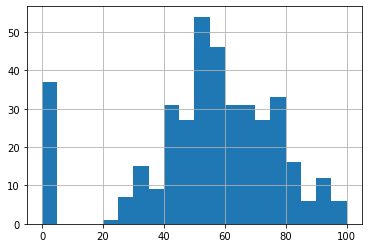

In [6]:
get_stat_values(students_scored, 'score', draw=True)

' Судя по данным шкала оценки по математике 100 бальная с шагом 5.\n\n    Оценки распределены со смещением влево.\n    Аномальным кажется получение минимального (нулевого) балла 10% студентов. При этом отсутствуют студенты\n    получившие оценки в интервале 0 > x > 20, что еще больше подчеркивает изолированность этой группы.\n\n    Можно предположить, что получение нулевого балла не связано с самим итоговым тестированием (экзаменом),\n    по видимому мы имеем дело с двумя зависимостями и двумя группами студентов:\n        1. Студенты, к которым применялась обычная система оценки. Для которых график распределения оценок\n        близок к нормальному.\n        2. Студенты, получившие нулевой балл и условия попадания в данную группу. Возможно они вообще не были допущены\n        до экзамена, или были допущены, но их оценивали не так как прочих студентов.\n\n    Для разделения данных групп я ввожу колонку \'score_group\' поскольку считаю что для данных групп критерии влияющие на\n    оценк

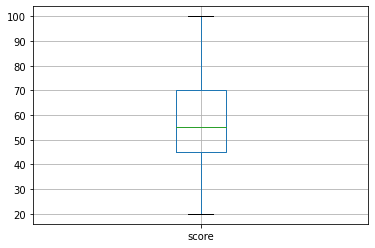

In [7]:
students_scored.query('score > 0').boxplot(column='score')

''' Судя по данным шкала оценки по математике 100 бальная с шагом 5.

    Оценки распределены со смещением влево.
    Аномальным кажется получение минимального (нулевого) балла 10% студентов. При этом отсутствуют студенты
    получившие оценки в интервале 0 > x > 20, что еще больше подчеркивает изолированность этой группы.

    Можно предположить, что получение нулевого балла не связано с самим итоговым тестированием (экзаменом),
    по видимому мы имеем дело с двумя зависимостями и двумя группами студентов:
        1. Студенты, к которым применялась обычная система оценки. Для которых график распределения оценок
        близок к нормальному.
        2. Студенты, получившие нулевой балл и условия попадания в данную группу. Возможно они вообще не были допущены
        до экзамена, или были допущены, но их оценивали не так как прочих студентов.

    Для разделения данных групп я ввожу колонку 'score_group' поскольку считаю что для данных групп критерии влияющие на
    оценку могут отличаться и для анализа 1ой группы оценка "0" - является выбросом, мешающим оценить факторы влияющие
    на балл.

    Полагая, что группа №2 выходит за рамки данного исследования, корреляционный анализ будет проведен для группы №1,
    с использованием query('score_group == 1')

    Также интересно наличие выраженного "плато" в интервале от 40 до 80 баллов. Это может быть связано с тем, что
    экзаменаторы с одной стороны "дотягивают" одних студентов до 40, а с другой неохотно дают оценку выше 80 баллов.
    С другой стороны это также может быть связано с методом экзаменации, например, есть базовый блок задач,
    знакомых большинству экзаменуемых, и задачи повышенной сложности, которые большинство студентов среднего
    уровня решить не может.
    '''

Медиана: 55.0, 25-й перцентиль: 45.0, 75-й перцентиль: 70.0, IQR: 25.0,  
Границы выбросов: [7.5, 107.5].


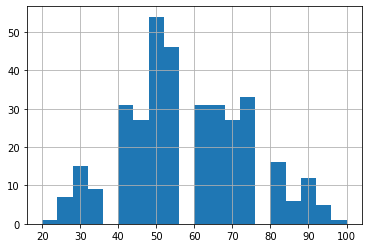

In [8]:
'''данные по оценкам для студентов получивших более 0 баллов'''
students_scored['score_group'] = students_scored['score'].apply(lambda x: 1 if x > 0 else 2)
get_stat_values(students_scored.query('score_group == 1'), 'score', draw=True)

#### school

In [9]:
get_field_info(students_scored, 'school')
''' Есть данные по двум школам, данные присутствуют для всех студентов
    Очистка данных не требуется'''


Value counts:     school
GP     344
MS      45

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  389 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Есть данные по двум школам, данные присутствуют для всех студентов\n    Очистка данных не требуется'

#### sex

In [10]:
get_field_info(students_scored, 'sex')
''' Также полные данные, ничего неожиданного
    Очистка данных не требуется'''


Value counts:    sex
F  204
M  185

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     389 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Также полные данные, ничего неожиданного\n    Очистка данных не требуется'

#### age


Value counts:     age
16  103
17   98
15   82
18   80
19   21
20    3
22    1
21    1

Unique values: 8

Appeared more then 10 times: 5

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     389 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB
Медиана: 17.0, 25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  
Границы выбросов: [13.0, 21.0].


' Есть данные по возрасту для всех студентов в интервале от 15 до 22, ничего неожиданного.\n    Очистка данных не требуется. 22 года выходит за границу выбросов, однако я не считаю это выбросом в данным случае'

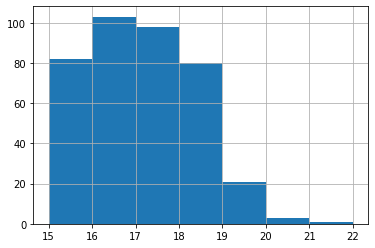

In [11]:
get_field_info(students_scored, 'age')
get_stat_values(students_scored, 'age', draw=True, bins=7)
''' Есть данные по возрасту для всех студентов в интервале от 15 до 22, ничего неожиданного.
    Очистка данных не требуется. 22 года выходит за границу выбросов, однако я не считаю это выбросом в данным случае'''

#### address

In [12]:
get_field_info(students_scored, 'address')
''' Данные есть для 374 студентов из 389.
    Очистка данных не требуется '''


Value counts:    address
U      291
R       83

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  374 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 374 студентов из 389.\n    Очистка данных не требуется '

#### famsize

In [13]:
get_field_info(students_scored, 'famsize')
''' Данные есть для 362 студентов из 389.
    Очистка данных не требуется '''


Value counts:      famsize
GT3      255
LE3      107

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  362 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 362 студентов из 389.\n    Очистка данных не требуется '

#### Pstatus

In [14]:
get_field_info(students_scored, 'Pstatus')
''' Данные есть 344 студентов из 389.
    Очистка данных не требуется '''


Value counts:    Pstatus
T      308
A       36

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pstatus  344 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть 344 студентов из 389.\n    Очистка данных не требуется '

#### Medu

In [15]:
get_field_info(students_scored, 'Medu')
''' Данные есть для 386 студентов из 389.
    Очистка данных не требуется '''


Value counts:      Medu
4.0   131
2.0   100
3.0    96
1.0    56
0.0     3

Unique values: 5

Appeared more then 10 times: 4

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Medu    386 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


' Данные есть для 386 студентов из 389.\n    Очистка данных не требуется '

#### Fedu

In [16]:
students_scored.Fedu = students_scored.Fedu.apply(lambda x: x if 0 <= x <= 4 else None)
get_field_info(students_scored, 'Fedu')
''' Данные есть для 364 студентов из 389.
    Одна запись содержала неправильный код для типа образования - 40,
    колонка очищена от значений выходящих за рамки интервала от 0 до 4'''


Value counts:      Fedu
2.0   105
3.0    94
4.0    88
1.0    75
0.0     2

Unique values: 5

Appeared more then 10 times: 4

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fedu    364 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


' Данные есть для 364 студентов из 389.\n    Одна запись содержала неправильный код для типа образования - 40,\n    колонка очищена от значений выходящих за рамки интервала от 0 до 4'

#### Mjob

In [17]:
get_field_info(students_scored, 'Mjob')
''' Данные есть для 370 студентов из 389.
    Очистка данных не требуется '''


Value counts:           Mjob
other      127
services    98
at_home     58
teacher     55
health      32

Unique values: 5

Appeared more then 10 times: 5

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Mjob    370 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 370 студентов из 389.\n    Очистка данных не требуется '

#### Fjob

In [18]:
get_field_info(students_scored, 'Fjob')
''' Данные есть для 353 студентов из 389.
    Очистка данных не требуется '''


Value counts:           Fjob
other      194
services    99
teacher     29
at_home     16
health      15

Unique values: 5

Appeared more then 10 times: 5

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Fjob    353 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 353 студентов из 389.\n    Очистка данных не требуется '

#### reason

In [19]:
get_field_info(students_scored, 'reason')
''' Данные есть для 372 студентов из 389.
    Отчистка данных не требуется '''


Value counts:             reason
course         135
reputation     102
home           101
other           34

Unique values: 4

Appeared more then 10 times: 4

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  372 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 372 студентов из 389.\n    Отчистка данных не требуется '

#### guardian

In [20]:
get_field_info(students_scored, 'guardian')
''' Данные есть для 358 студентов из 389.
    Отчистка данных не требуется '''


Value counts:         guardian
mother       248
father        86
other         24

Unique values: 3

Appeared more then 10 times: 3

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  358 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 358 студентов из 389.\n    Отчистка данных не требуется '

#### traveltime


Value counts:      traveltime
1.0         239
2.0          94
3.0          21
4.0           7

Unique values: 4

Appeared more then 10 times: 3

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  361 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 1.0, 25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  
Границы выбросов: [-0.5, 3.5].


' Данные есть для 361 студентов из 389.\n    Отчистка данных не требуется\n    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:\n    а. данные сгруппированы\n    б. я не вижу чтобы они были получены в результате ошибки\n    в. данные могут быть важны для анализа'

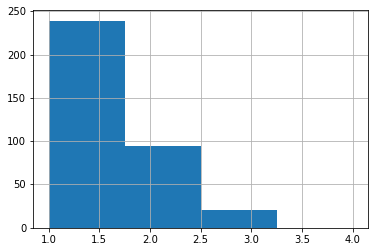

In [41]:
get_field_info(students_scored, 'traveltime')
get_stat_values(students_scored, 'traveltime', draw=True, bins=4)
''' Данные есть для 361 студентов из 389.
    Отчистка данных не требуется
    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:
    а. данные сгруппированы
    б. я не вижу чтобы они были получены в результате ошибки
    в. данные могут быть важны для анализа'''

#### studytime


Value counts:      studytime
2.0        189
1.0        103
3.0         63
4.0         27

Unique values: 4

Appeared more then 10 times: 4

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  382 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 2.0, 25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  
Границы выбросов: [-0.5, 3.5].


' Данные есть для 382 студентов из 389.\n    Отчистка данных не требуется\n    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:\n    а. данные сгруппированы\n    б. я не вижу чтобы они были получены в результате ошибки\n    в. данные могут быть важны для анализа'

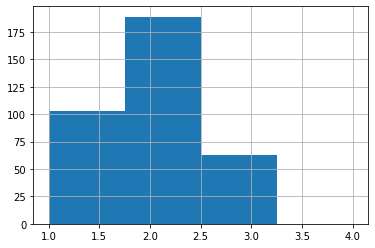

In [42]:
get_field_info(students_scored, 'studytime')
get_stat_values(students_scored, 'studytime', draw=True, bins=4)

''' Данные есть для 382 студентов из 389.
    Отчистка данных не требуется
    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:
    а. данные сгруппированы
    б. я не вижу чтобы они были получены в результате ошибки
    в. данные могут быть важны для анализа'''

#### failures


Value counts:      failures
0.0       290
1.0        48
2.0        15
3.0        14

Unique values: 4

Appeared more then 10 times: 4

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 0.0, 25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  
Границы выбросов: [0.0, 0.0].


' Данные есть для 367 студентов из 389.\n    Отчистка данных не требуется\n    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:\n    а. данные сгруппированы\n    б. я не вижу чтобы они были получены в результате ошибки\n    в. данные могут быть важны для анализа'

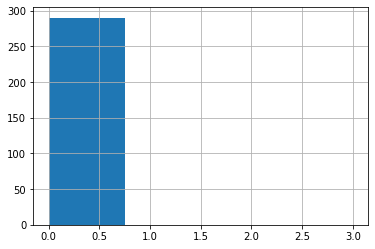

In [43]:
get_field_info(students_scored, 'failures')
get_stat_values(students_scored, 'failures', draw=True, bins=4)

''' Данные есть для 367 студентов из 389.
    Отчистка данных не требуется
    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:
    а. данные сгруппированы
    б. я не вижу чтобы они были получены в результате ошибки
    в. данные могут быть важны для анализа'''

#### schoolsup

In [24]:
get_field_info(students_scored, 'schoolsup')
''' Данные есть для 380 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      schoolsup
no         331
yes         49

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  380 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 380 студентов из 389.\n    Отчистка данных не требуется '

#### famsup

In [25]:
get_field_info(students_scored, 'famsup')
''' Данные есть для 351 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      famsup
yes     216
no      135

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  351 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 351 студентов из 389.\n    Отчистка данных не требуется '

#### paid

In [26]:
get_field_info(students_scored, 'paid')
''' Данные есть для 350 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      paid
no    197
yes   153

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 350 студентов из 389.\n    Отчистка данных не требуется '

#### activities

In [27]:
get_field_info(students_scored, 'activities')
''' Данные есть для 375 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      activities
yes         192
no          183

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 375 студентов из 389.\n    Отчистка данных не требуется '

#### nursery

In [28]:
get_field_info(students_scored, 'nursery')
''' Данные есть для 374 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      nursery
yes      297
no        77

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  374 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 374 студентов из 389.\n    Отчистка данных не требуется '

#### higher

In [29]:
get_field_info(students_scored, 'higher')
''' Данные есть для 369 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      higher
yes     350
no       19

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  369 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 369 студентов из 389.\n    Отчистка данных не требуется '

#### internet

In [30]:
get_field_info(students_scored, 'internet')
''' Данные есть для 355 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      internet
yes       300
no         55

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 355 студентов из 389.\n    Отчистка данных не требуется '

#### romantic

In [31]:
get_field_info(students_scored, 'romantic')
''' Данные есть для 358 студентов из 389.
    Отчистка данных не требуется '''


Value counts:      romantic
no        235
yes       123

Unique values: 2

Appeared more then 10 times: 2

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  358 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


' Данные есть для 358 студентов из 389.\n    Отчистка данных не требуется '

#### famrel


Value counts:      famrel
2.0     105
3.0      94
4.0      88
1.0      77

Unique values: 4

Appeared more then 10 times: 4

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  364 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 2.5, 25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  
Границы выбросов: [0.5, 4.5].


' Данные есть для 364 студентов из 389.\n    Одно из значений было как -1, решено приводить нулвые и отрицательные значения к 1,\n    поскольку предполагается, что подразумевались крайне плохие отношения\n    Примечательно, что никто из студентов не оценил внутрисемейные отношения как "5 - очень хорошие"\n    Распредение нормалньое, выбросов нет.'

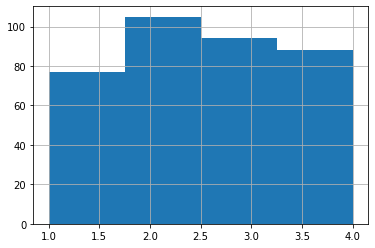

In [49]:
students_scored.famrel = students_scored.Fedu.apply(lambda x: x if 1 <= x <= 5 else 1 if x < 1 else None)
get_field_info(students_scored, 'famrel')
get_stat_values(students_scored, 'famrel', draw=True, bins=4)

''' Данные есть для 364 студентов из 389.
    Одно из значений было как -1, решено приводить нулвые и отрицательные значения к 1,
    поскольку предполагается, что подразумевались крайне плохие отношения
    Примечательно, что никто из студентов не оценил внутрисемейные отношения как "5 - очень хорошие"
    Распредение нормалньое, выбросов нет.'''

#### freetime


Value counts:      freetime
3.0       152
4.0       110
2.0        63
5.0        37
1.0        18

Unique values: 5

Appeared more then 10 times: 5

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  380 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 3.0, 25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  
Границы выбросов: [1.5, 5.5].


' Данные есть для 380 студентов из 389.\n    Отчистка данных не требуется\n    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:\n    а. данные сгруппированы\n    б. я не вижу чтобы они были получены в результате ошибки\n    в. данные могут быть важны для анализа'

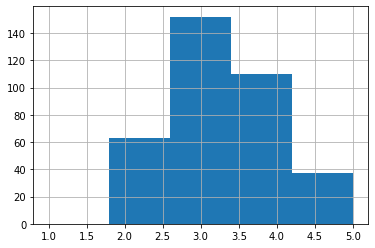

In [46]:
get_field_info(students_scored, 'freetime')
get_stat_values(students_scored, 'freetime', draw=True, bins=5)
''' Данные есть для 380 студентов из 389.
    Отчистка данных не требуется
    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:
    а. данные сгруппированы
    б. я не вижу чтобы они были получены в результате ошибки
    в. данные могут быть важны для анализа'''

#### goout


Value counts:      goout
3.0    126
2.0    101
4.0     81
5.0     51
1.0     23

Unique values: 5

Appeared more then 10 times: 5

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   382 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 3.0, 25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  
Границы выбросов: [-1.0, 7.0].


' Данные есть для 382 студентов из 389.\n    Отчистка данных не требуется\n    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:\n    а. данные сгруппированы\n    б. я не вижу чтобы они были получены в результате ошибки\n    в. данные могут быть важны для анализа '

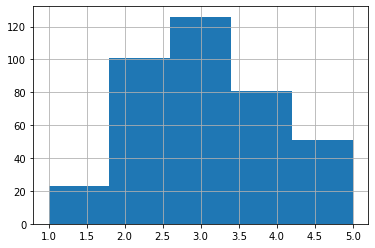

In [50]:
get_field_info(students_scored, 'goout')
get_stat_values(students_scored, 'goout', draw=True, bins=5)

''' Данные есть для 382 студентов из 389.
    Отчистка данных не требуется
    Распредение нормальное, выбросов нет '''

#### health


Value counts:      health
5.0     137
3.0      88
4.0      60
1.0      47
2.0      42

Unique values: 5

Appeared more then 10 times: 5

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  374 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 4.0, 25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  
Границы выбросов: [0.0, 8.0].


' Данные есть для 374 студентов из 389.\n    Отчистка данных не требуется\n    В данном случае я не считаю значения выходящие за границы выбросов - выбросами, поскольку:\n    а. данные сгруппированы\n    б. я не вижу чтобы они были получены в результате ошибки\n    в. данные могут быть важны для анализа '

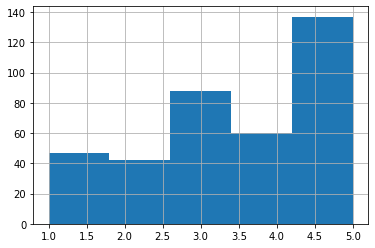

In [52]:
get_field_info(students_scored, 'health')
get_stat_values(students_scored, 'health', draw=True, bins=5)
''' Данные есть для 374 студентов из 389.
    Отчистка данных не требуется
    Распределение со смещением вправо, выбросов нет. '''

#### absences

In [36]:
get_field_info(students_scored, 'absences')
get_stat_values(students_scored, 'absences')

''' Данные есть для 378 студентов из 389.
    Отчистка данных не требуется
    Есть выбросы, часть студентов имеет значительно большее число прогулов чем остальные.
    Я считаю что в данном случае имеет смысл таже сгруппировать данные, как это сделано в предыдущих случаях,
    а не считать прогулы количественно, группировка:
    1 - x = 0
    2 - 0 < x < 5
    3 - 5 <= x < 10
    4 - 10 <= x < 20
    5 - x >= 20
    '''

students_scored['absences_grouped'] = students_scored['absences']\
    .apply(lambda x: group_absences(x) if type(x) == float else None)

get_field_info(students_scored, 'absences_grouped')


Value counts:        absences
0.0         110
2.0          60
4.0          52
6.0          30
8.0          20
10.0         17
12.0         12
14.0         12
3.0           7
16.0          7
7.0           6
5.0           5
18.0          5
20.0          4
22.0          3
9.0           3
1.0           3
15.0          2
13.0          2
11.0          2
25.0          1
54.0          1
385.0         1
26.0          1
56.0          1
24.0          1
212.0         1
21.0          1
75.0          1
30.0          1
19.0          1
38.0          1
40.0          1
23.0          1
17.0          1
28.0          1

Unique values: 36

Appeared more then 10 times: 8

General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  378 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB
Медиана: 4.0, 25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0

In [37]:
''' существует корреляция между получением нулевого балла и количеством пропусков'''
students_scored[['absences_grouped', 'score_group']].corr()

,absences_grouped,score_group
absences_grouped,1.000000,-0.339879
score_group,-0.339879,1.000000


### Корреляционный анализ

#### Числовые данные

In [38]:
''' Я не отнес Medu и Fedu к числовым данным, поскольку считаю что в данном случае корреляция не покажет
    реальной картины, среднее специальное техническое образование родителя может помочь больше чем высшее
    историческое

    Также я не отнес к числовым данным критерии выраженные числом, но отражающиее лишь субъективное восприятие,
    такие как famrel или freetime, поскольку внутренняя шакала ощущения у всех разная и для кого-то 4 часа с друьзями
    это много а для кого-то мало, что приводит к необъективной группировке времени'''

students_scored.query('score_group == 1')\
    [['score', 'age', 'traveltime', 'studytime', 'absences_grouped']].corr()

,score,age,traveltime,studytime,absences_grouped
score,1.000000,-0.131542,-0.075516,0.142055,-0.169161
age,-0.131542,1.000000,0.095370,-0.011426,0.201097
traveltime,-0.075516,0.095370,1.000000,-0.101490,-0.022682
studytime,0.142055,-0.011426,-0.101490,1.000000,-0.070098
absences_grouped,-0.169161,0.201097,-0.022682,-0.070098,1.000000


Наблюдается положительная корреляция между временем затраченным на учебу и оценкой.

Наблюдается отрецательная корреляция между возрастом и оценкой - молодые студенты сдают экзамены лучше.

Наблюдается отрецательная корреляция между количеством пропущенных занятий и оценкой - те кто пропускает чаще,
в среднем имеют худшие оценки.

Будет убрано из набора данных: traveltime, поскольку её корреляция с оценкой представляется незначительной.


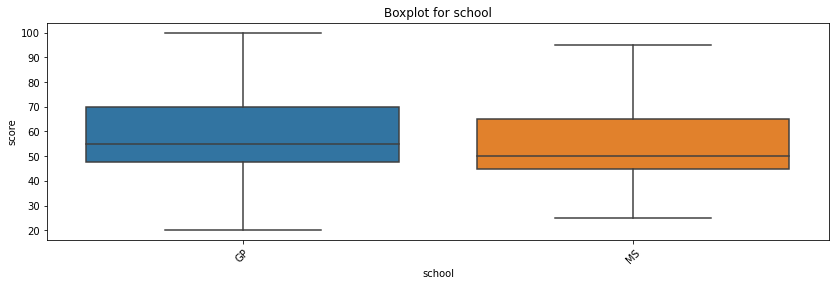

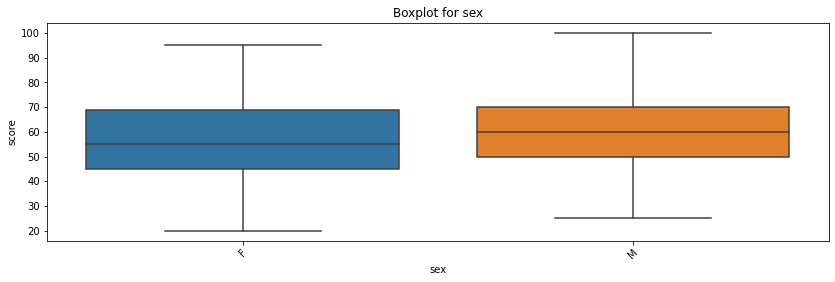

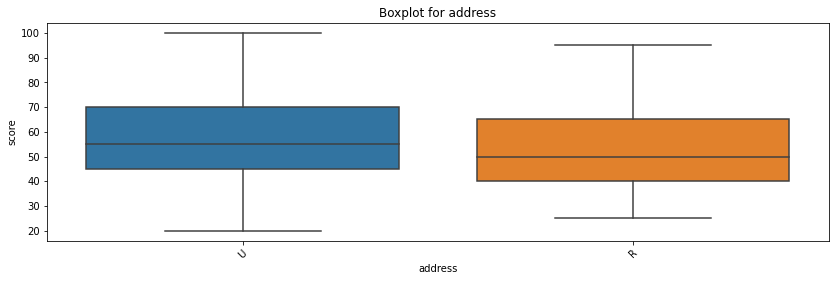

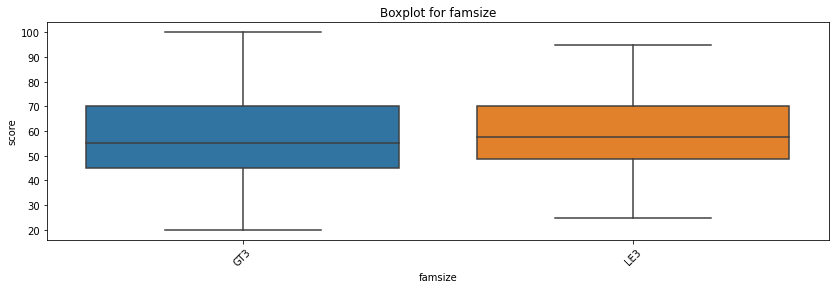

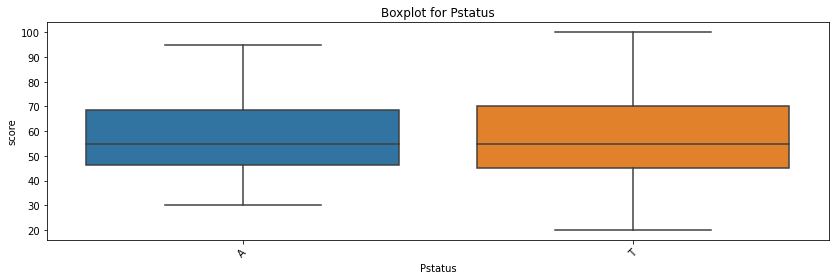

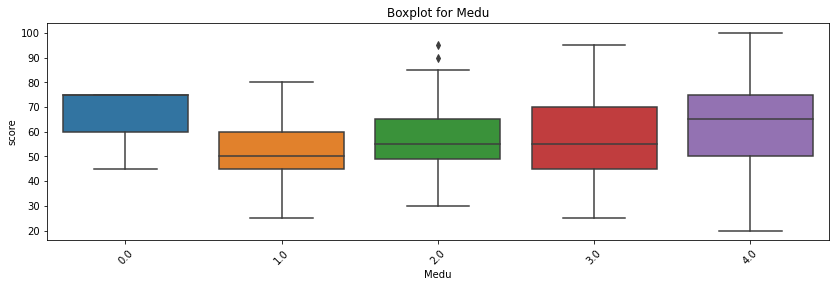

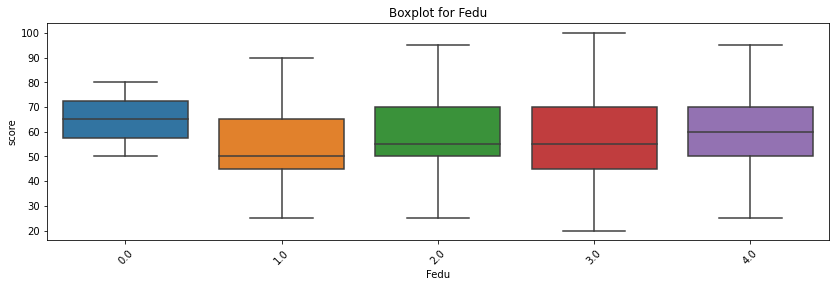

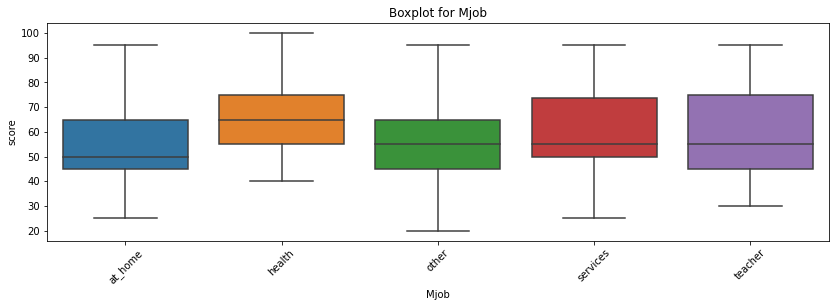

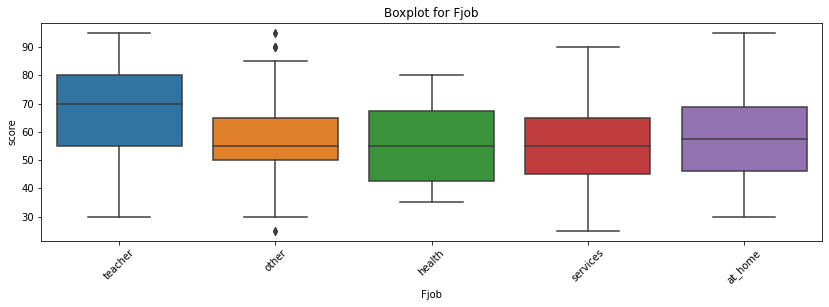

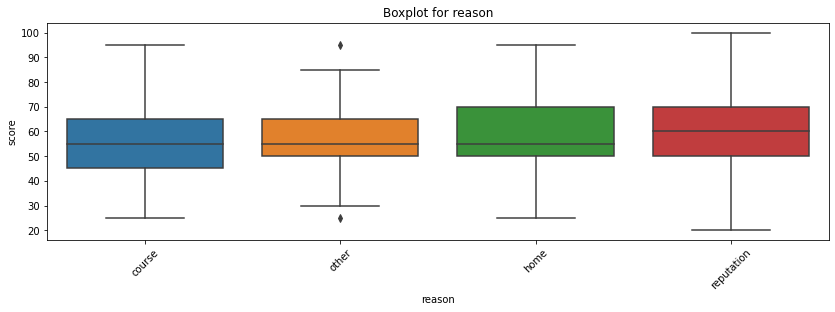

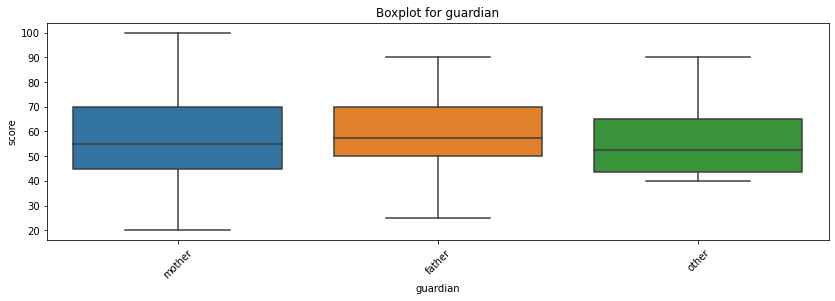

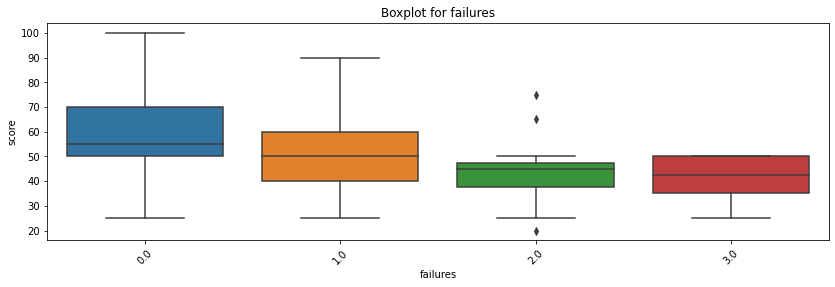

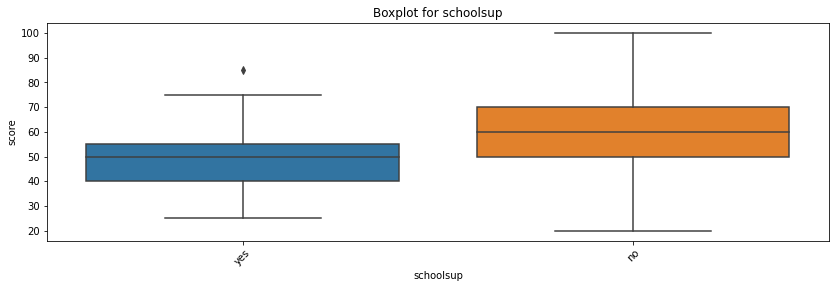

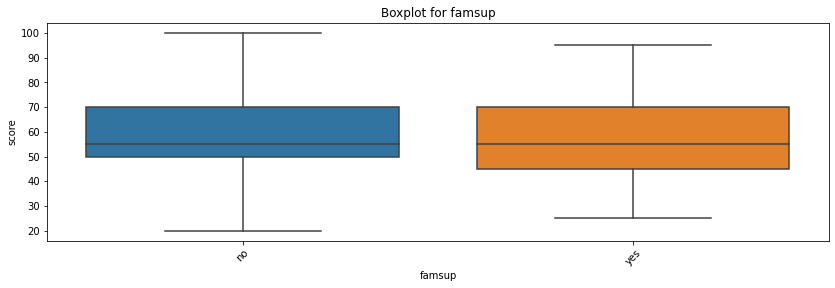

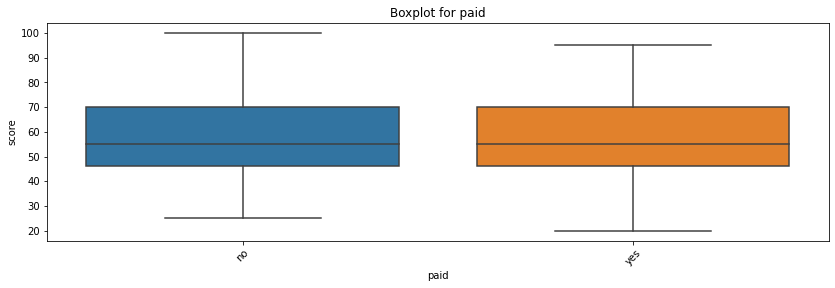

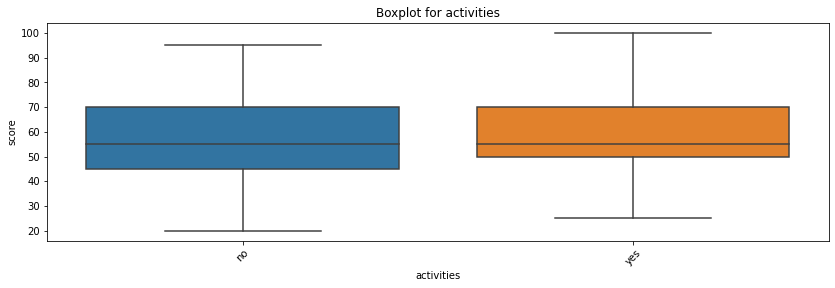

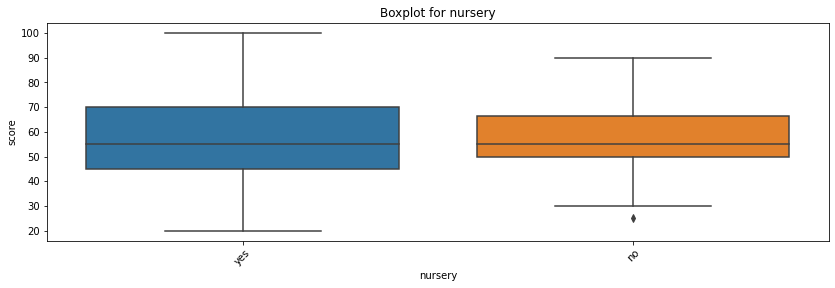

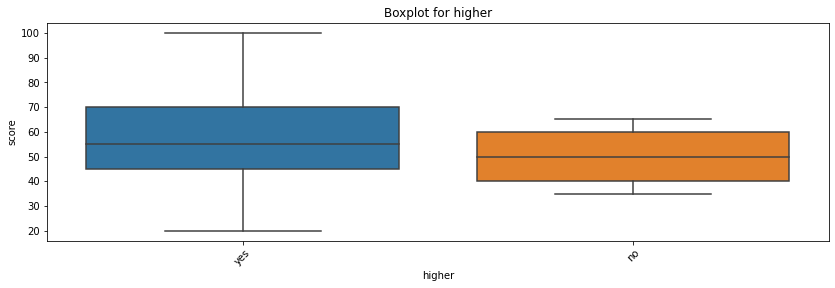

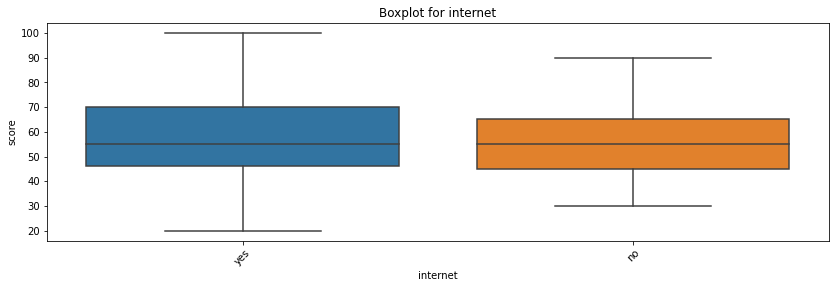

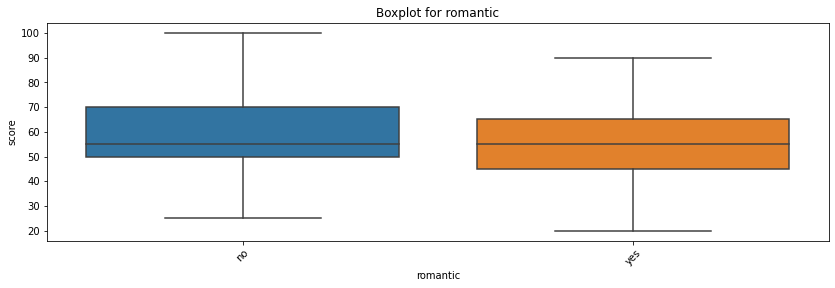

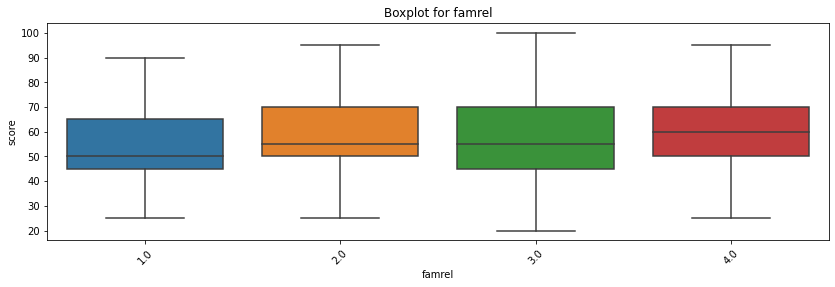

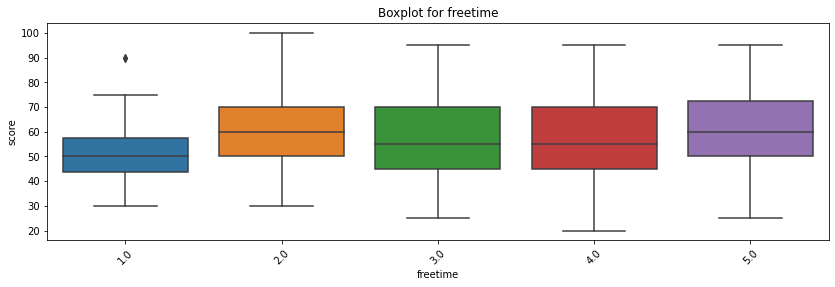

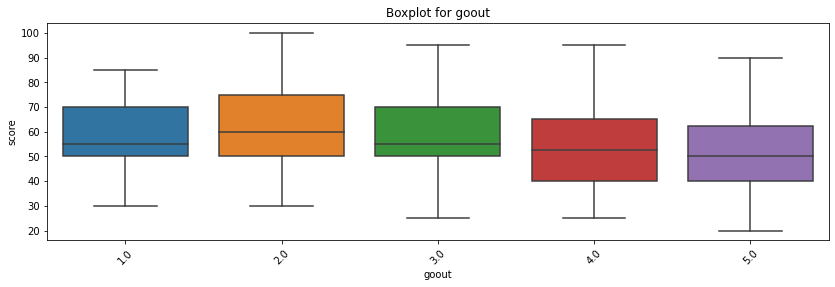

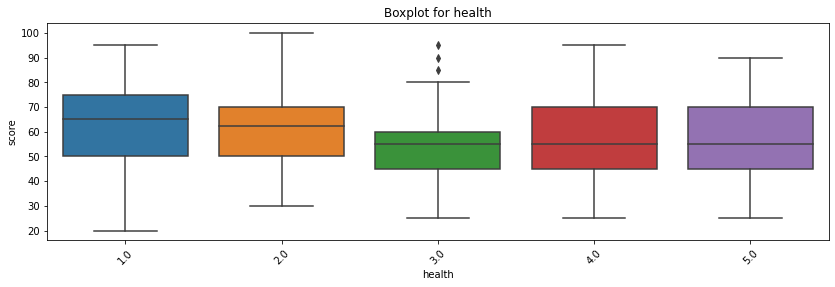

Найдены статистически значимые различия для колонки  address
Найдены статистически значимые различия для колонки  Medu
Найдены статистически значимые различия для колонки  Fedu
Найдены статистически значимые различия для колонки  Mjob
Найдены статистически значимые различия для колонки  Fjob
Найдены статистически значимые различия для колонки  failures
Найдены статистически значимые различия для колонки  schoolsup
Найдены статистически значимые различия для колонки  famrel
Найдены статистически значимые различия для колонки  goout


In [39]:
for column in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
               'reason', 'guardian', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
               'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']:
    get_boxplot_by_score(students_scored.query('score_group == 1'), column)

for column in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
               'reason', 'guardian', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
               'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']:
    get_stat_dif(students_scored.query('score_group == 1'), column)

Учащиеся школы GP в среднем имеют немного лучший балл по математике.

Несколько уучше сдают экзамены студенты живщие в городе, по сравнению с тем кто живет за городом.

Наблюдается влияние образования и профессии родителей, особоенно ярко видно влияние профессии отца.

Явно видно влияние количества внеучебных неудач.

Доп. образовательная поддержку имеет влияение на оценку, однако негативную. Студены получющие поддержку сдают экзамены
хуже.

Отношения в семье влияют на оценку.

Нежелание получить высшее образование серьезно влияет на оценку. Хотя количество студентов не желающих получить высшее
образование очень невелико в процентном выражении, ~5%.

Также видно некоторое влияние на оценку количества времени проведенного с друзьями, здоровья.

Девочки в целом имеют лучшие оценки чем мальчики, но не имеет смысла рекомендовать смену пола как изменение условий
жизни для улучшения оценки по математике.

Будут убраны из набора данных: sex, famsize, Pstatus, reason, guardian, famsup, paid, activities, nursery,
internet, romantic, freetime.


In [53]:
students_result = students_scored[['score', 'age', 'school', 'studytime', 'absences_grouped',
                                   'address', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'failures',
                                   'schoolsup', 'higher', 'famrel', 'health', 'goout']]

,score,age,school,studytime,absences_grouped,address,Medu,Fedu,Mjob,Fjob,failures,schoolsup,higher,famrel,health,goout
0,30.0,18,GP,2.0,3,U,4.0,4.0,at_home,teacher,0.0,yes,yes,4.0,3.0,4.0
1,30.0,17,GP,2.0,2,U,1.0,1.0,at_home,other,0.0,no,yes,1.0,3.0,3.0
2,50.0,15,GP,2.0,4,U,1.0,1.0,at_home,other,3.0,yes,yes,1.0,3.0,2.0
3,75.0,15,GP,3.0,2,U,4.0,2.0,health,NaN,0.0,no,yes,2.0,5.0,2.0
4,50.0,16,GP,2.0,2,U,3.0,3.0,other,other,0.0,no,yes,3.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,45.0,20,MS,2.0,5,U,2.0,2.0,services,services,2.0,no,yes,2.0,4.0,4.0
385,80.0,17,MS,1.0,2,U,3.0,1.0,services,services,0.0,no,yes,1.0,2.0,5.0
386,35.0,21,MS,1.0,2,R,1.0,1.0,other,other,3.0,NaN,NaN,1.0,3.0,3.0
387,50.0,18,MS,1.0,1,R,3.0,2.0,services,other,0.0,no,yes,2.0,5.0,1.0


## Выводы

Судя по данным шкала оценки по математике 100 бальная с шагом 5.

Аномальным кажется получение минимального (нулевого) балла 10% студентов. При этом отсутствуют студенты
получившие оценки в интервале 0 > x > 20, что еще больше подчеркивает изолированность этой группы.

Можно предположить, что получение нулевого балла не связано с самим итоговым тестированием (экзаменом),
по видимому мы имеем дело с двумя зависимостями и двумя группами студентов:
    1. Студенты, к которым применялась обычная система оценки. Для которых график распределения оценок
    близок к нормальному.
    2. Студенты, получившие нулевой балл и условия попадания в данную группу. Возможно они вообще не были допущены
    до экзамена, или были допущены, но их оценивали не так как прочих студентов.

Для разделения данных групп я ввожу колонку 'score_group' поскольку считаю что для данных групп критерии влияющие на
оценку могут отличаться и для анализа 1ой группы оценка "0" - является выбросом, мешающим оценить факторы влияющие
на балл.

Полагая, что группа №2 выходит за рамки данного исследования, корреляционный анализ будет проведен для группы №1,
с использованием query('score_group == 1')

Также интересно наличие выраженного "плато" в интервале от 40 до 80 баллов. Это может быть связано с тем, что
экзаменаторы с одной стороны "дотягивают" одних студентов до 40, а с другой неохотно дают оценку выше 80 баллов.
С другой стороны это также может быть связано с методом экзаменации, например, есть базовый блок задач,
знакомых большинству экзаменуемых, и задачи повышенной сложности, которые большинство студентов среднего
уровня решить не может.

В том что касается влияния различных факторов на оценку, похоже что оно (влияние) комплексное, то есть не существует
одной определяющей причины. Вообще было трудно выделить фактры которые однозначно не влияют на оценку, и я решил
отобрать те для которых влиянение более выраженно исходя из того что я вижу.

Очень предварительно я бы сгруппировал и расположил их в следующем порядке по степени влияния:
    1. внеучебные проблемы
    2. учебная мотивация студента (желание тратить время на учебу)
    3. влияние семьи
    4. прочие факторы